# Chisquare test

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# ignore warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')
##### Read & preprocess the data (from kostat) #####
df_raw23 = pd.read_csv('data\\2023_household.csv',encoding='CP949')
selected_cols = ["조사연도","수도권여부","MD제공용_가구고유번호","가구주_성별코드","가구주_만연령","가구원수","가구주_교육정도_학력코드","가구주_혼인상태코드","자산","부채","처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]","가구주_산업대분류코드","가구주_직업대분류코드","입주형태코드"]
df23 = df_raw23[selected_cols]
df23.rename(columns={"조사연도":"year","수도권여부":"metro","MD제공용_가구고유번호":"id","가구주_성별코드":"sex","가구주_만연령":"age","가구원수":"number","가구주_교육정도_학력코드":"education","가구주_혼인상태코드":"marriage","자산":"asset","부채":"debt","처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]":"income","가구주_산업대분류코드":"industry","가구주_직업대분류코드":"job","입주형태코드":"house"},inplace=True)
print(df23.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18094 entries, 0 to 18093
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       18094 non-null  int64 
 1   metro      18094 non-null  object
 2   id         18094 non-null  int64 
 3   sex        18094 non-null  int64 
 4   age        18094 non-null  int64 
 5   number     18094 non-null  int64 
 6   education  18094 non-null  int64 
 7   marriage   18094 non-null  int64 
 8   asset      18094 non-null  int64 
 9   debt       18094 non-null  int64 
 10  income     18094 non-null  int64 
 11  industry   13356 non-null  object
 12  job        13356 non-null  object
 13  house      18094 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 1.9+ MB
None


In [12]:
##### Test of income difference according to occupation #####
##### occupational types #####
# 1 : 관리자
# 2 : 전문가 및 관련 종사자
# 3 : 사무 종사자
# 4 : 서비스 종사자
# 5 : 판매 종사자
# 6 : 농림어업 숙련？종사자
# 7 : 기능원 및 관련 기능 종사자
# 8 : 장치,기계조작 및 조립 종사자
# 9 : 단순노무 종사자
# A : 군인
print("Job category : ", df23['job'].unique())
df23 = df23[['sex','job']]
print(df23.info())

Job category :  ['4' '5' '2' '9' nan '3' '8' '7' '1' '6' 'A']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18094 entries, 0 to 18093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     18094 non-null  int64 
 1   job     13356 non-null  object
dtypes: int64(1), object(1)
memory usage: 282.8+ KB
None


In [13]:
print("# of nulls :", df23['job'].isnull().sum())
df23 = df23.dropna()
print(df23.info())

# of nulls : 4738
<class 'pandas.core.frame.DataFrame'>
Index: 13356 entries, 0 to 18093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     13356 non-null  int64 
 1   job     13356 non-null  object
dtypes: int64(1), object(1)
memory usage: 313.0+ KB
None


In [14]:
##### Option: Removal of groups (soldiers) comprised mostly of men. (as a duty in Korea)#####
## 군인같은 특수 카테고리 없애기(특히 군인은 남성같은 경우 원하지 않은 직업선택일 수 있으므로 비교에 부적합)
df23 = df23.drop(df23[(df23.job=="A")].index)
print(df23.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13330 entries, 0 to 18093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     13330 non-null  int64 
 1   job     13330 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.4+ KB
None


In [15]:
##### Display the observation frequency: Gender distribution by job #####
print("##### Observation Frequency #####")
tab1 = pd.crosstab(df23.sex, df23.job, margins=True) #margins=True : Include total values
tab2 = pd.crosstab(df23.sex, df23.job) #margins=True : Include total values
print(tab1)

##### Observation Frequency #####
job    1     2     3     4     5     6     7     8     9    All
sex                                                            
1    285  1572  1519   581   808  1024  1371  1716  1339  10215
2     17   542   388   701   327   192    76    78   794   3115
All  302  2114  1907  1282  1135  1216  1447  1794  2133  13330


In [16]:
print(tab2)

job    1     2     3    4    5     6     7     8     9
sex                                                   
1    285  1572  1519  581  808  1024  1371  1716  1339
2     17   542   388  701  327   192    76    78   794


In [17]:
##### Calculate the expected frequency #####
### number of people
tot = tab1.iloc[-1, -1]  # total number of people (13330)

j_1 = tab1.iloc[-1, 0]   # 실제 직업1을 가진 사람 수
j_2 = tab1.iloc[-1, 1]
j_3 = tab1.iloc[-1, 2]
j_4 = tab1.iloc[-1, 3]
j_5 = tab1.iloc[-1, 4]
j_6 = tab1.iloc[-1, 5]
j_7 = tab1.iloc[-1, 6]
j_8 = tab1.iloc[-1, 7]
j_9 = tab1.iloc[-1, 8]

tot_m = tab1.iloc[0, -1]  # 실제 남자 인원수 (10215)
tot_f = tab1.iloc[1, -1]  # 실제 여자 인원수 (3115)


In [18]:
##### Calculate the expected frequency #####
### make the tab2
tab2 = pd.crosstab(df23.sex, df23.job, margins=True)

p_m = tot_m / tot  # 전체 인구 중 남자인구의 비율
p_f = tot_f / tot  # 전체 인구 중 여자인구의 비율

p_j1 = j_1 / tot   #전체 직업 중 1번 직업의 비율
p_j2 = j_2 / tot
p_j3 = j_3 / tot
p_j4 = j_4 / tot
p_j5 = j_5 / tot
p_j6 = j_6 / tot
p_j7 = j_7 / tot
p_j8 = j_8 / tot
p_j9 = j_9 / tot

# Expected # of men in each occupation
tab2.iloc[0, 0] = tot * p_m * p_j1 # 이상적인 직업 1중 남자의 명수(전체*남자비율 = 남자인원, 남자인원* 직업1비율)
tab2.iloc[0, 1] = tot * p_m * p_j2
tab2.iloc[0, 2] = tot * p_m * p_j3
tab2.iloc[0, 3] = tot * p_m * p_j4
tab2.iloc[0, 4] = tot * p_m * p_j5
tab2.iloc[0, 5] = tot * p_m * p_j6
tab2.iloc[0, 6] = tot * p_m * p_j7
tab2.iloc[0, 7] = tot * p_m * p_j8
tab2.iloc[0, 8] = tot * p_m * p_j9
tab2.iloc[0, 9] = sum(tab2.iloc[0, 0:9])

# Expected # of women in each occupation
tab2.iloc[1, 0] = tot * p_f * p_j1
tab2.iloc[1, 1] = tot * p_f * p_j2
tab2.iloc[1, 2] = tot * p_f * p_j3
tab2.iloc[1, 3] = tot * p_f * p_j4
tab2.iloc[1, 4] = tot * p_f * p_j5
tab2.iloc[1, 5] = tot * p_f * p_j6
tab2.iloc[1, 6] = tot * p_f * p_j7
tab2.iloc[1, 7] = tot * p_f * p_j8
tab2.iloc[1, 8] = tot * p_f * p_j9
tab2.iloc[1, 9] = sum(tab2.iloc[1, 0:9])

In [19]:
##### Calculate the expected frequency #####
##### Display the observation frequency: Gender distribution by job #####
print ("##### Expected Frequency####")
print (tab2)

##### Expected Frequency####
job           1            2            3            4            5  \
sex                                                                   
1    231.427607  1619.993248  1461.365716   982.417854   869.769317   
2     70.572393   494.006752   445.634284   299.582146   265.230683   
All  302.000000  2114.000000  1907.000000  1282.000000  1135.000000   

job           6           7            8            9      All  
sex                                                             
1     931.84096  1108.86009  1374.771943  1634.553263  10215.0  
2     284.15904   338.13991   419.228057   498.446737   3115.0  
All  1216.00000  1447.00000  1794.000000  2133.000000  13330.0  


In [20]:
##### Observation - Expectation #####
############# diff 구하기 ############
tab3 = pd.crosstab(df23.sex, df23.job, margins=True)

num_rows = tab3.shape[0]
num_cols = tab3.shape[1]

for i in range(num_rows):
    for j in range(num_cols):
        tab3.iloc[i, j] = tab1.iloc[i, j] - tab2.iloc[i, j]

print("##### Observations - Expected #####")
print(tab3)


##### Observations - Expected #####
job          1          2          3           4          5         6  \
sex                                                                     
1    53.572393 -47.993248  57.634284 -401.417854 -61.769317  92.15904   
2   -53.572393  47.993248 -57.634284  401.417854  61.769317 -92.15904   
All   0.000000   0.000000   0.000000    0.000000   0.000000   0.00000   

job          7           8           9           All  
sex                                                   
1    262.13991  341.228057 -295.553263  0.000000e+00  
2   -262.13991 -341.228057  295.553263  4.547474e-13  
All    0.00000    0.000000    0.000000  0.000000e+00  


In [21]:
##### Chi-square score #####
chi_square = []

for i in range(num_rows):
    for j in range(num_cols):
        t = (tab1.iloc[i, j] - tab2.iloc[i, j])**2 / tab2.iloc[i, j]
        chi_square.append(t)

DF = (num_rows - 1) * (num_cols - 1)
chi_square_tot = sum(chi_square)
print("Chi-square score:", round(chi_square_tot, 4))

##### Chi-square test #####
import scipy.stats as stats
p_value = 1 - stats.chi2.cdf(chi_square_tot, DF)
print("P-value:", p_value)


Chi-square score: 1684.8632
P-value: 0.0


# F-test(ANOVA)
**분산 분석 (ANOVA)**

- ANOVA는 세 개 이상의 독립적인 (서로 관련 없는) 그룹 간 평균에 통계적으로 유의한 차이가 있는지를 결정하는 데 사용
- 그룹 평균 간의 관찰된 변동이 실제 차이로 인한 것인지 아니면 무작위 요인으로 인한 것인지 판별

- ANOVA를 올바르게 적용하려면 몇 가지 가정을 충족해야 한다.
  1. 서로 다른 그룹의 데이터는 서로 독립적이어야 한다.
  2. 각 그룹 내의 데이터는 대략적으로 정규 분포를 따라야 한다.
  3. 그룹 간의 분산은 대략적으로 같아야 한다 (동분산성).

**ANOVA 수행 단계**

1. 가설 설정:
   - 귀무 가설 (H₀): 모든 그룹 평균이 동일합니다 ($\mu_1=\mu_2=\mu_3=…=\mu_k$).
   - 대립 가설 (H₁): 최소한 하나의 그룹 평균이 다릅니다.

2. F-통계량 계산:
   - F-통계량은 그룹 간 분산과 그룹 내 분산의 비율입니다.
   - 그룹 간 분산: 그룹 간의 상호작용으로 인한 변동을 측정합니다.
   - 그룹 내 분산: 각 그룹 내의 변동을 측정합니다.
   - F = (그룹 간 변동 / 그룹 내 변동)

3. F-통계량 분석:
   - 계산된 F-값을 지정된 유의 수준(일반적으로 0.05)의 F-분포 표에서 중요한 값과 비교합니다.
   - F-통계량에 해당하는 p-값이 유의 수준보다 작으면 귀무 가설을 기각합니다.

**결과 해석**

- Significant Result (p < 0.05): 그룹 평균 간에 통계적으로 유의한 차이가 있음을 나타냅니다. 특정 그룹 간 차이를 식별하기 위해 추가 사후 검정(예: Tukey의 HSD)이 자주 수행됩니다.

- Non significant Result (p >= 0.05): 그룹 평균 간에 유의한 차이가 있다는 증거가 없음을 시사합니다.

**ANOVA의 응용**

- ANOVA는 심리학, 교육, 의학, 비즈니스 등 다양한 분야에서 그룹 평균 간의 차이에 대한 가설을 테스트하는 데 널리 사용됩니다. 여러 치료나 조건을 비교하는 실험 설계에서 특히 유용합니다.

**ANOVA의 종류**

- One way ANOVA: 하나의 독립 변수를 기준으로 세 개 이상의 그룹 평균을 비교할 때 사용됩니다. 단일 요인의 영향을 평가합니다.

  - 예: 연구자가 다른 다이어트가 체중 감량에 미치는 영향을 조사하고자 합니다. 독립 변수는 다이어트 유형(Diet A, Diet B, Diet C)이고, 종속 변수는 특정 기간 후의 체중 감량량입니다.
  - 귀무 가설 (H₀): 세 가지 다이어트 모두에서 평균 체중 감량이 동일합니다 ($\mu_1=\mu_2=\mu_3$).
  - 대립 가설 (H₁): 최소한 하나의 다이어트가 다른 평균 체중 감량을 초래합니다.

연구자는 각각의 다이어트를 따르는 세 그룹의 참가자들로부터 체중 감량 데이터를 수집합니다. 일원 ANOVA를 수행하여 연구자는 세 다이어트 그룹 간에 평균 체중 감량의 유의한 차이가 있는지 여부를 확인할 수 있습니다.

**Two way ANOVA: 두 개의 독립 변수가 종속 변수에 미치는 영향을 조사할 때 사용됩니다. 각 요인의 주 효과와 그들 간의 상호작용 효과를 평가할 수 있습니다.**

- 예: 연구자가 다른 교수 방법과 학생 성별이 시험 점수에 미치는 영향을 연구하고자 합니다. 독립 변수는 교수 방법(Method A, Method B)과 성별(Male, Female)이며, 종속 변수는 시험 점수입니다.

- 귀무 가설 (H₀):
  - 교수 방법 간 시험 점수 평균에 차이가 없습니다 ($\mu$Method A=$\mu$MethodB).
  - 성별 간 시험 점수 평균에 차이가 없습니다 ($\mu$Male=$\mu$Female).
  - 교수 방법과 성별이 시험 점수에 미치는 상호작용 효과가 없습니다.

- 대립 가설 (H₁):
  - 최소한 하나의 교수 방법이 다른 평균 시험 점수를 초래합니다.
  - 최소한 한 성별이 다른 평균 시험 점수를 가집니다.
  - 교수 방법과 성별 간의 상호작용 효과가 있습니다.
    - 위 3가지에 대해 각각의 sig level과 p-value가 존재한다

연구자는 두 가지 교수 방법을 사용하여 가르친 남학생과 여학생의 시험 점수를 수집합니다. 이원 ANOVA를 수행하여 연구자는 다음을 확인할 수 있습니다:

교수 방법이 시험 점수에 유의한 영향을 미치는지 여부.
성별이 시험 점수에 유의한 영향을 미치는지 여부.
교수 방법과 성별 간에 상호작용 효과가 시험 점수에 유의한 영향을 미치는지 여부.

![IMG](MDA16_1.png)

예시: 연령대별로 하루에 인스타그램 사용 횟수가 다른지 알아봅시다 (20대, 30대, 40대). 각 연령대에서 세 명의 개인을 관찰하여 인스타그램 애플리케이션을 얼마나 자주 사용하는지 확인했습니다.

![IMG](MDA16_2.png)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ignore warnings
warnings.filterwarnings('ignore')

##### Read & preprocess the data (from kostat) #####
df_raw23 = pd.read_csv('data\\2023_household.csv', encoding='CP949')

selected_cols = [
    "조사연도", "수도권여부", "MD제공용_가구고유번호", "가구주_성별코드", "가구주_만연령", "가구원수",
    "가구주_교육정도_학력코드", "가구주_혼인상태코드", "자산", "부채",
    "처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]", "가구주_산업대분류코드", "가구주_직업대분류코드",
    "입주형태코드"
]

df23 = df_raw23[selected_cols]
df23.rename(columns={
    "조사연도": "year", "수도권여부": "metro", "MD제공용_가구고유번호": "id", "가구주_성별코드": "sex",
    "가구주_만연령": "age", "가구원수": "number", "가구주_교육정도_학력코드": "education",
    "가구주_혼인상태코드": "marriage", "자산": "asset", "부채": "debt",
    "처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]": "income",
    "가구주_산업대분류코드": "industry", "가구주_직업대분류코드": "job", "입주형태코드": "house"
}, inplace=True)

print(df23.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18094 entries, 0 to 18093
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       18094 non-null  int64 
 1   metro      18094 non-null  object
 2   id         18094 non-null  int64 
 3   sex        18094 non-null  int64 
 4   age        18094 non-null  int64 
 5   number     18094 non-null  int64 
 6   education  18094 non-null  int64 
 7   marriage   18094 non-null  int64 
 8   asset      18094 non-null  int64 
 9   debt       18094 non-null  int64 
 10  income     18094 non-null  int64 
 11  industry   13356 non-null  object
 12  job        13356 non-null  object
 13  house      18094 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 1.9+ MB
None


In [3]:
##### Test of income difference according to education level #####
df23 = df23[['income', 'education']]
print("Education Level : ", df23['education'].unique())

##### Option : Remove the outliers #####
# fare_q3 = df23['income'].quantile(q=0.75)
# fare_q1 = df23['income'].quantile(q=0.25)
# fare_iqr = fare_q3 - fare_q1
# condition = df23['income'] <= 3 * fare_iqr
# df23 = df23[condition]

##### Group into 3 groups #####
target1 = [1, 2, 3]
target2 = [4, 5]
target3 = [6, 7, 8]

df23 = df23.loc[df23['education'].isin(target1 + target2 + target3)]
df23_L = df23.loc[df23['education'].isin(target1)]
df23_M = df23.loc[df23['education'].isin(target2)]
df23_H = df23.loc[df23['education'].isin(target3)]
print(df23_L.tail(10))

##### Education levels #####
# 1: 안받음(미취학포함)
# 2: 초등학교
# 3: 중학교
# 4: 고등학교
# 5: 대학(3년제 이하)
# 6: 대학교(4년제 이상)
# 7: 대학원석사
# 8: 대학원박사 이상


Education Level :  [2 4 5 6 3 7 1 8]
       income  education
18039    2703          2
18045    2162          2
18056    2315          2
18057    6077          3
18063    3708          3
18067     656          3
18068     589          1
18079    1825          2
18088    2697          2
18093    6537          3


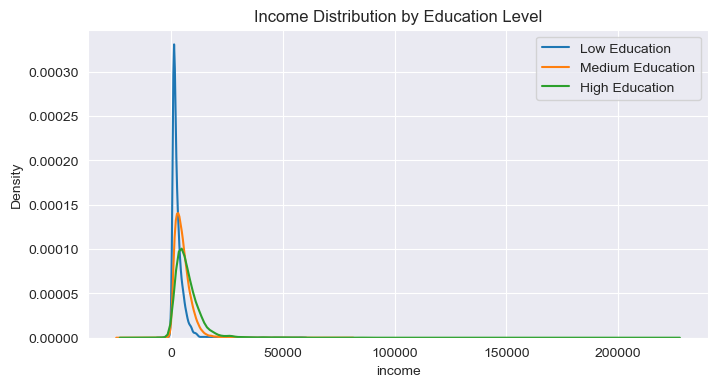

In [4]:
##### Select only income data #####
df23_ic = df23['income']
df23_L_ic = df23_L['income']
df23_M_ic = df23_M['income']
df23_H_ic = df23_H['income']

##### Plot income distribution among three groups #####
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.distplot(df23_L_ic, hist=False, label='Low Education')
sns.distplot(df23_M_ic, hist=False, label='Medium Education')
sns.distplot(df23_H_ic, hist=False, label='High Education')
# plt.xlim(-50000, 50000)
plt.title('Income Distribution by Education Level')
plt.legend()
plt.show()


In [5]:
##### Calculate the F-score #####

### 1. Means of each group
mean = df23_ic.mean()
mean_L = df23_L_ic.mean()
mean_M = df23_M_ic.mean()
mean_H = df23_H_ic.mean()
print("\n1. Total mean:", mean)
print("   Group1's mean:", mean_L)
print("   Group2's mean:", mean_M)
print("   Group3's mean:", mean_H)

### 2. SSb (Sum of squares of between-group variance)
SSb_L = ((mean_L - mean) ** 2) * len(df23_L_ic)
SSb_M = ((mean_M - mean) ** 2) * len(df23_M_ic)
SSb_H = ((mean_H - mean) ** 2) * len(df23_H_ic)
SSb = SSb_L + SSb_M + SSb_H
print("2. SSb:", SSb)

### 3. SSw (Sum of squares of within-group variance)
SSw_L = sum((df23_L_ic - mean_L) ** 2)
SSw_M = sum((df23_M_ic - mean_M) ** 2)
SSw_H = sum((df23_H_ic - mean_H) ** 2)
SSw = SSw_L + SSw_M + SSw_H
print("3. SSw:", SSw)

### 4. SSt (Sum of squares of total variance)
SSt = sum((df23_ic - mean) ** 2)
print("4. SSt:", SSt)



1. Total mean: 5053.512656129104
   Group1's mean: 2711.5560237502395
   Group2's mean: 5082.0217276797475
   Group3's mean: 7328.727221064595
2. SSb: 55969386995.12541
3. SSw: 384780917925.4763
4. SSt: 440750304920.60223


In [6]:
##### Calculate the F-score #####

### 5. Degree of freedoms
k = 3
n = len(df23)
DFb = k - 1
DFw = n - k
DFt = n - 1
print("5. DFb: %d, DFw: %d, DFt: %d" % (DFb, DFw, DFt))

### 6. Mean squares
MSb = SSb / DFb
MSw = SSw / DFw
print("6. MSb: %f, MSw: %f" % (MSb, MSw))


5. DFb: 2, DFw: 18091, DFt: 18093
6. MSb: 27984693497.562706, MSw: 21269190.090403


In [8]:
##### Calculate the F-score #####

### 7. F-score
f_score = MSb / MSw
print("\n7. F_score:", f_score)

### 8. P-value (Significant level)
import scipy as sp
import scipy.stats

rv = sp.stats.f(DFb, DFw)     # A normal continuous random variable (mu=0, var=1)
p_value = np.round(1 - rv.cdf(f_score), 5)
print("8. Significant Level (p-value):", p_value)



7. F_score: 1315.73855791482
8. Significant Level (p-value): 0.0


In [10]:


##### Hypothesis Test #####
print("\n### Hypothesis Test ###\nConsidering a 5% significance level,")
if p_value < 0.05:
    print("p_value(%f) < 0.05, therefore reject H0, and accept H1." % p_value)
else:
    print("p_value(%f) > 0.05, therefore, Cannot reject H0." % p_value)

### 9. Another way to get F-score & P-value (Significant level)
print("\n*** Another way: ")
f_statistics, p_value = sp.stats.f_oneway(df23_L_ic, df23_M_ic, df23_H_ic)
print("f-score", f_statistics)
print("p-value:", p_value)



### Hypothesis Test ###
Considering a 5% significance level,
p_value(0.000000) < 0.05, therefore reject H0, and accept H1.

*** Another way: 
f-score 1315.7385579148206
p-value: 0.0
